In [1]:
import xarray as xr
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

from data_processor import DataProcessor
from regressor import Regressor

In [2]:
ds = xr.open_dataset("../data.grib")
t2m_numpy = ds.t2m.to_numpy() - 273.15  # -> C
sp_numpy = ds.sp.to_numpy() / 100       # -> hPa

data = np.stack((t2m_numpy, sp_numpy), axis=-1)
feature_list = [ds.t2m.name, ds.sp.name]

auto_seq_len = 5 # AUTOREG_SEQUENCE_LENGTH ---> input_size
fh = 2           # FORECASTING_HORIZON

processor = DataProcessor(data)
X, y = processor.preprocess(auto_seq_len, fh)
X_train, X_test, y_train, y_test = processor.train_test_split(X, y)

/home/kamil/Desktop/git/meteoapp-data/venv/lib/python3.11/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.30.0
  warnings.warn(


In [3]:
X.shape, y.shape

((1076, 3, 25, 45, 2), (1076, 2, 25, 45, 2))

In [4]:
X.shape, y.shape

((1076, 3, 25, 45, 2), (1076, 2, 25, 45, 2))

<=== linear ===>
RMSE t2m: 6.664; R2 t2m: -5.801
RMSE sp: 1.505; R2 sp: 0.993


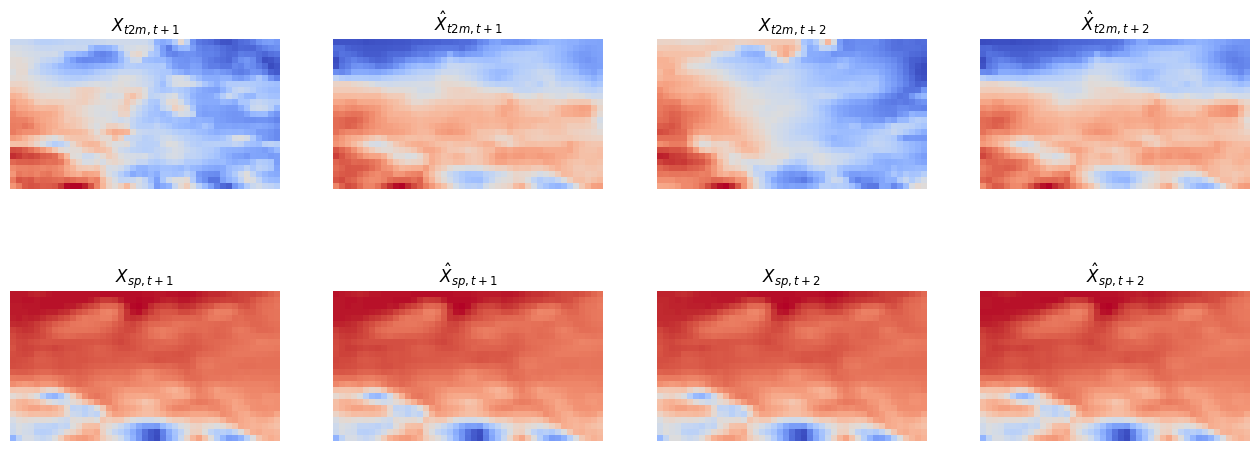

RMSE t2m: 1.672; R2 t2m: 0.563
RMSE sp: 2.776; R2 sp: 0.977


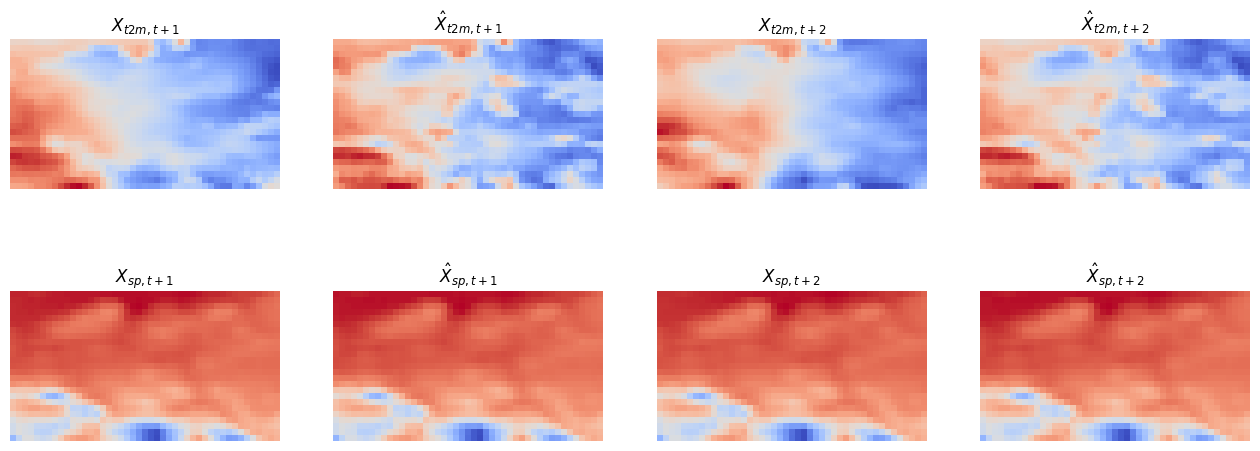

RMSE t2m: 3.075; R2 t2m: 0.38
RMSE sp: 2.01; R2 sp: 0.988


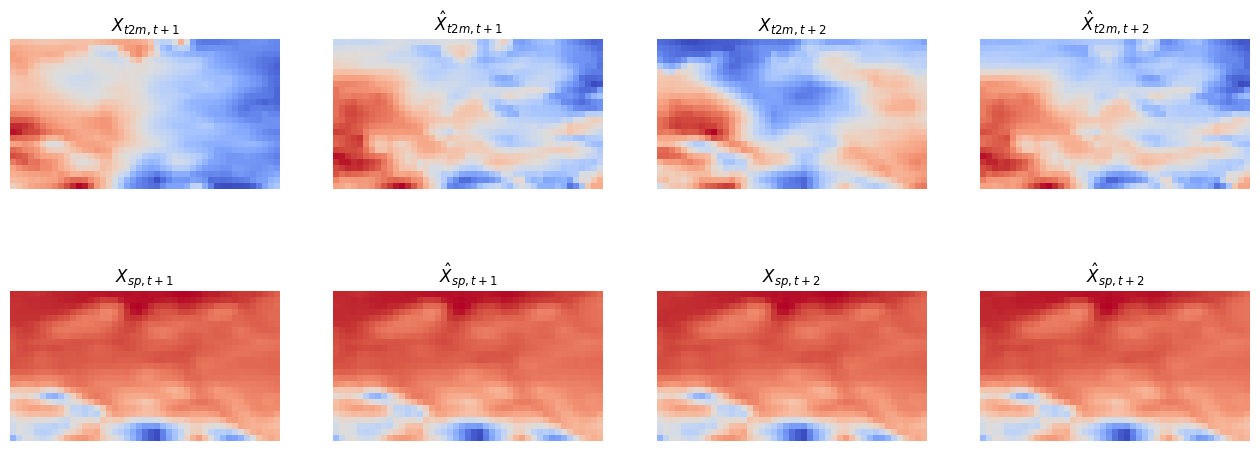

Evaluation metrics for entire test set:
RMSE t2m: 4.446499509586684; R2 t2m: 0.10127046301269682
RMSE sp: 1.797309182999618; R2 sp: 0.9919672548033093






In [5]:
available_regressors = ["linear"] #, "ridge", "lasso", "elastic_net"]

for reg in available_regressors:
    print(f'<=== {reg} ===>')
    linearreg = Regressor(X.shape, fh, feature_list, regressor_type=reg)
    linearreg.train(X_train, y_train)
    _ = linearreg.predict_and_evaluate(X_test, y_test, limit=3)
    print('\n\n\n')